In [1]:
import numpy as np

from dataset import CarlaDataset

train_dataset = CarlaDataset(["data/Town05",
                              "data/Town07",
                              "data/Town03"])

test_dataset = CarlaDataset(["data/Town10"])

In [2]:
image, segm = next(train_dataset)

In [3]:
# from tqdm import tqdm
#
# alls = set()
#
# with tqdm(total=len(dataset)) as t:
#     for _, item in dataset:
#         for label in np.unique(item):
#             alls.add(label)
#
#         t.set_postfix_str(f"Count: {len(alls)}")
#         t.update(1)

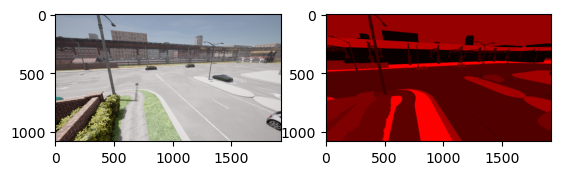

In [4]:
from matplotlib import pyplot as plt
import numpy as np

segm_gr = segm.copy()
segm_gr = segm_gr / np.max(segm_gr) * 255
segm_gr = np.array(segm_gr, dtype=np.uint8)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image)
axes[1].imshow(segm_gr, cmap='gray')

[ 0  1  5  6  7  8  9 10 11 14 16 20 22 25]


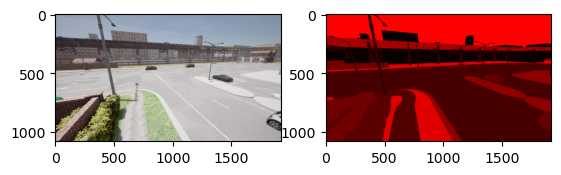

In [5]:
segm_gr = segm.copy()
segm_gr[segm_gr == 13] = 25
print(np.unique(segm_gr))
segm_gr = segm_gr / np.max(segm_gr) * 255
segm_gr = np.array(segm_gr, dtype=np.uint8)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(image)
axes[1].imshow(segm_gr, cmap='gray')

In [6]:
import torch

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

In [7]:
next(iter(train_dataloader))

[tensor([[[[ 1.2214,  1.2385,  1.2385,  ...,  1.0331,  1.0331,  1.0331],
           [ 0.1597,  0.2282,  0.3138,  ...,  1.0331,  1.0331,  1.0331],
           [-0.4226, -0.4054, -0.3883,  ...,  1.0331,  1.0331,  1.0331],
           ...,
           [ 1.1872,  1.0159,  1.1187,  ...,  0.8618,  0.9988,  0.9646],
           [ 1.1187,  1.0673,  1.1358,  ...,  1.1358,  1.1872,  1.0673],
           [ 1.1529,  1.1187,  1.2214,  ...,  0.9988,  1.0673,  1.0159]],
 
          [[ 1.1155,  1.1331,  1.1331,  ...,  0.9930,  0.9930,  0.9930],
           [ 0.0826,  0.1176,  0.2227,  ...,  0.9930,  0.9930,  0.9930],
           [-0.5126, -0.5126, -0.4951,  ...,  0.9930,  0.9930,  0.9930],
           ...,
           [ 1.3782,  1.2381,  1.3256,  ...,  1.0105,  1.0805,  1.0980],
           [ 1.3431,  1.2906,  1.3431,  ...,  1.2731,  1.3431,  1.2031],
           [ 1.3431,  1.3256,  1.3782,  ...,  1.1506,  1.2206,  1.1681]],
 
          [[ 1.0539,  1.0714,  1.0714,  ...,  0.9668,  0.9668,  0.9494],
           [ 

In [8]:
from PIDNet.models.pidnet import get_pred_model, get_seg_model

model = get_seg_model(model_name='test',
                      path_to_pretrained='PIDNet\\pretrained_models\\cityscapes\\PIDNet_M_Cityscapes_val.pt',
                      num_classes=23, imgnet_pretrained=False)

In [9]:
from torch.optim import SGD
from PIDNet.utils.utils import FullModel
from PIDNet.utils.criterion import BondaryLoss, OhemCrossEntropy, CrossEntropy

device = torch.device('cuda')
class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345,
                                   1.0166, 0.9969, 0.9754, 1.0489,
                                   0.8786, 1.0023, 0.9539, 0.9843,
                                   1.1116, 0.9037, 1.0865, 1.0955,
                                   1.0865, 1.1529, 1.0507, 1,
                                   1, 1, 1]).to(device)

sem_criterion = OhemCrossEntropy(ignore_label=-1,
                                 thres=0.9,
                                 min_kept=131072,
                                 weight=class_weights)
# sem_criterion = CrossEntropy(ignore_label=-1, weight=class_weights)

bd_criterion = BondaryLoss()
model = FullModel(model, sem_criterion, bd_criterion).to(device)
optimizer = SGD(model.parameters(), lr=0.005)



In [ ]:

import os
from tqdm import tqdm
from PIDNet.utils.function import train, validate
import torch.backends.cudnn as cudnn

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
EPOCHS = 200
epoch_iters = len(train_dataloader)
num_iters = EPOCHS * epoch_iters
cudnn.benchmark = True
cudnn.deterministic = False
cudnn.enabled = True

best_mIoU = 0
real_end = 200

for epoch in range(EPOCHS):
    train(epoch=epoch + 1, num_epoch=EPOCHS, epoch_iters=len(train_dataloader), base_lr=0.01, num_iters=num_iters,
              trainloader=train_dataloader, optimizer=optimizer, model=model)
    valid_loss, mean_IoU, IoU_array = validate(test_dataloader, model)

    if mean_IoU > best_mIoU:
        best_mIoU = mean_IoU
        torch.save(model.model.state_dict(),
                   os.path.join('checkpoints', 'best.pt'))

Epoch: [1/200] Iter:[620/626], Time: 1.19, lr: [0.00991038657668638], Loss: 4.010136, Acc:0.649460, Semantic loss: 1.341702, BCE loss: 1.856963, SB loss: 0.811471: 100%|██████████| 626/626 [12:24<00:00,  1.19s/it] 
Validate loss: 4.859178911555902: 100%|██████████| 198/198 [04:42<00:00,  1.43s/it] 
I:1, mean IoU:0.05201984996809021: 0it [00:00, ?it/s]
Epoch: [2/200] Iter:[620/626], Time: 1.12, lr: [0.00986533014991078], Loss: 3.307883, Acc:0.718251, Semantic loss: 1.042401, BCE loss: 1.597975, SB loss: 0.667507: 100%|██████████| 626/626 [11:43<00:00,  1.12s/it] 
Validate loss: 4.204793519443934: 100%|██████████| 198/198 [05:16<00:00,  1.60s/it] 
I:1, mean IoU:0.06369967400409031: 0it [00:00, ?it/s]
Epoch: [3/200] Iter:[620/626], Time: 1.13, lr: [0.009820250847056775], Loss: 3.117126, Acc:0.741322, Semantic loss: 0.973167, BCE loss: 1.506017, SB loss: 0.637942: 100%|██████████| 626/626 [11:46<00:00,  1.13s/it]
Validate loss: 3.7850447471695716: 100%|██████████| 198/198 [04:46<00:00,  1.

In [11]:
pred_model = model.model
pred_model.load_state_dict(torch.load('checkpoints/best.pt'))

<All keys matched successfully>

In [12]:
image, segm = next(train_dataset)

image_t = torch.tensor(image).permute(2, 0, 1) / 255
image_t = torch.unsqueeze(image_t, dim=0)
segm_gr = segm.copy()
segm_gr = segm_gr / np.max(segm_gr) * 255
segm_gr = np.array(segm_gr, dtype=np.uint8)
pred_model.eval()
out = pred_model(image_t.cuda())

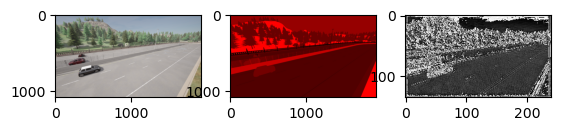

In [14]:
mask = (out[0] * 255).to(torch.uint8)
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(image)
axes[1].imshow(segm_gr, cmap='gray')
axes[2].imshow(mask[0][13].detach().cpu().numpy(), cmap='gray')